In [2]:
!pip install --no-deps simplejson
!pip install --no-deps citylearn==1.8.0
# !pip install --upgrade ipykernel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 10.7 MB/s eta 0:00:00


In [3]:
# system files
import sys, os

# type hinting
from typing import List, Mapping

# Data visualization
import time
import matplotlib.pyplot as plt

# Data manipulation
import numpy as np
import pandas as pd
from datetime import datetime

# CityLearn
from citylearn.citylearn import CityLearnEnv
from citylearn.data import DataSet

# custom modules
cwd = '/content/drive/MyDrive/Colab Notebooks/CityLearn_MPC'
sys.path.append(os.path.join(cwd))
from preprocessing import set_schema_buildings, set_schema_simulation_period, set_active_observations, get_timestep
from plot_kpi import plot_simulation_summary, plot_actions, plot_rewards
from mpc import MPC

%matplotlib inline

# Suppress DeprecationWarnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
DATASET_NAME = 'citylearn_challenge_2022_phase_all'
schema = DataSet.get_schema(DATASET_NAME)

root_directory = schema['root_directory']

In [6]:
# edit next code line to change number of buildings in simulation
BUILDING_INDEX = [7]

# edit next code line to change active observations in simulation
ACTIVE_OBSERVATIONS = ['month',
                       'day_type',
                       'hour',
                       'diffuse_solar_irradiance',
                       'diffuse_solar_irradiance_predicted_6h',
                       'diffuse_solar_irradiance_predicted_12h',
                       'direct_solar_irradiance',
                       'direct_solar_irradiance_predicted_6h',
                       'direct_solar_irradiance_predicted_12h',
                       'carbon_intensity',
                       'non_shiftable_load',
                       'solar_generation',
                       'electrical_storage_soc',
                       ]

schema, buildings = set_schema_buildings(schema, BUILDING_INDEX)
schema = set_active_observations(schema, ACTIVE_OBSERVATIONS)

print('Selected buildings:', buildings)
print(f'Active observations:', ACTIVE_OBSERVATIONS)

Selected buildings: ['Building_7']
Active observations: ['month', 'day_type', 'hour', 'diffuse_solar_irradiance', 'diffuse_solar_irradiance_predicted_6h', 'diffuse_solar_irradiance_predicted_12h', 'direct_solar_irradiance', 'direct_solar_irradiance_predicted_6h', 'direct_solar_irradiance_predicted_12h', 'carbon_intensity', 'non_shiftable_load', 'solar_generation', 'electrical_storage_soc']


In [7]:
# １つのAgentですべての住宅を制御
schema['central_agent'] = True

In [8]:
analysis_schema = schema.copy()

# Testing timestep
# START = get_timestep(6,24,0)
# STOP = get_timestep(6,30,23)

START = get_timestep(6,13,0)
STOP = get_timestep(6,16,23)

analysis_schema = set_schema_simulation_period(analysis_schema,
                                               START, STOP)

print(f'Selected time steps:', (START, STOP))

Selected time steps: (7584, 7679)


# Analysis

In [9]:
mpc_env = CityLearnEnv(analysis_schema)

In [9]:
mpc_de = MPC(analysis_schema,mpc_env,
          model_folder = os.path.join(cwd,"models"))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MultiOutputRegressor from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Building-level KPIs:


/content/drive/MyDrive/Colab Notebooks/CityLearn_MPC/plot_kpi.py:117: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


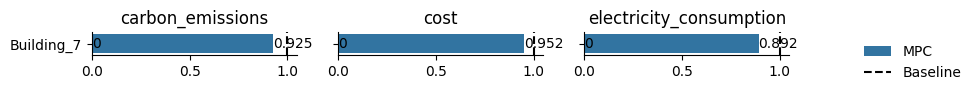

Building-level load profiles:


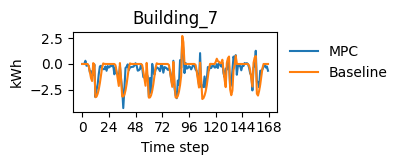

Battery SoC profiles:


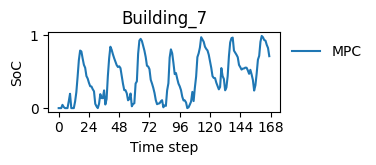

District-level KPIs:


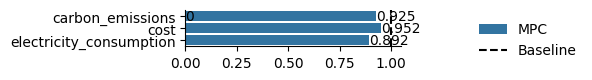

District-level load profiles:


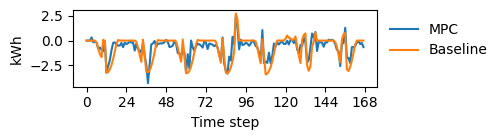

In [10]:
observations = mpc_env.reset()
actions_list = []
observations_list = []
hist_list = []
states_list = []

while not mpc_env.done:
    observations_list.append(observations)
    inputs = [d[k] for d in mpc_de.future_states.values() for k in d]
    inputs.append(mpc_de.future_electricity_pricing)
    inputs.append(mpc_de.future_carbon_intensity)
    states_list.append(np.array(inputs))
    hist = mpc_de.optimize(generations=2500)
    hist_list.append(hist)
    actions = mpc_de.predict_mpc()
    actions_list.append(actions)
    observations, _, _, _ = mpc_env.step([actions])
    mpc_de.update_mpc()

plot_simulation_summary(
    {'MPC': mpc_env}
)

In [11]:
np.savetxt(os.path.join(cwd, "month_analysis/actions4.txt"), np.array(actions_list), delimiter=",")

In [12]:
np.savetxt(os.path.join(cwd, "month_analysis/observations4.txt"), np.array(observations_list).reshape(-1,13), delimiter=",")

In [ ]:
np.savetxt(os.path.join(cwd, "month_analysis/states4.txt"), np.array(states_list), delimiter=",")

In [ ]:
np.savetxt(os.path.join(cwd, "month_analysis/history4.txt"), np.array(hist_list), delimiter=",")

In [ ]:
[plt.plot(hist_list[i]) for i in range(len(hist_list))];

#rerun

In [10]:
mpc_env = CityLearnEnv(analysis_schema)

In [11]:
mpc_de = MPC(analysis_schema,mpc_env,
          model_folder = os.path.join(cwd,"models"))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MultiOutputRegressor from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Building-level KPIs:


/content/drive/MyDrive/Colab Notebooks/CityLearn_MPC/plot_kpi.py:117: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


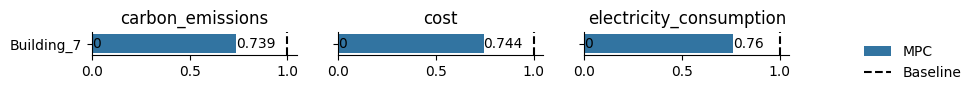

Building-level load profiles:


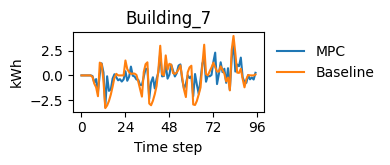

Battery SoC profiles:


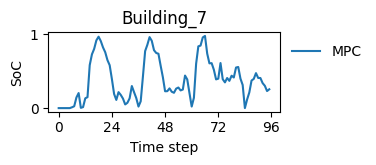

District-level KPIs:


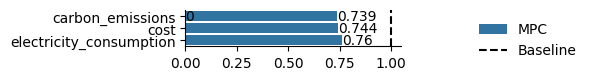

District-level load profiles:


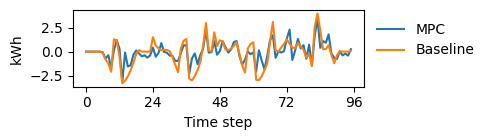

In [12]:
observations = mpc_env.reset()
actions_list = []
observations_list = []
hist_list = []
states_list = []

while not mpc_env.done:
    observations_list.append(observations)
    inputs = [d[k] for d in mpc_de.future_states.values() for k in d]
    inputs.append(mpc_de.future_electricity_pricing)
    inputs.append(mpc_de.future_carbon_intensity)
    states_list.append(np.array(inputs))
    hist = mpc_de.optimize(generations=2500)
    hist_list.append(hist)
    actions = mpc_de.predict_mpc()
    actions_list.append(actions)
    observations, _, _, _ = mpc_env.step([actions])
    mpc_de.update_mpc()

plot_simulation_summary(
    {'MPC': mpc_env}
)

In [ ]:
np.savetxt(os.path.join(cwd, "month_analysis/actions2_2.txt"), np.array(actions_list), delimiter=",")

In [ ]:
np.savetxt(os.path.join(cwd, "month_analysis/observations2_2.txt"), np.array(observations_list).reshape(-1,13), delimiter=",")

In [ ]:
np.savetxt(os.path.join(cwd, "month_analysis/states2_2.txt"), np.array(states_list), delimiter=",")

In [ ]:
np.savetxt(os.path.join(cwd, "month_analysis/history2_2.txt"), np.array(hist_list), delimiter=",")

In [ ]:
[plt.plot(hist_list[i]) for i in range(len(hist_list))];

# convergence check

In [19]:
mpc_env = CityLearnEnv(analysis_schema)

In [23]:
mpc_de = MPC(analysis_schema,mpc_env,
          model_folder = os.path.join(cwd,"models"))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MultiOutputRegressor from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [24]:
actions = mpc_de._generate_population()
obj = mpc_de.objective_function(actions)
best_obj_hist = [min(obj)]
convergence = [np.std(obj) / np.mean(obj)]

In [25]:
for i in range(2500):
    if convergence[-1] < 0.01:
        break
    new_actions = mpc_de._generate_new_actions(actions)

    new_obj = mpc_de.objective_function(new_actions)

    update_mask = new_obj < obj
    mpc_de._update_actions(actions, new_actions, update_mask)
    obj[update_mask] = new_obj[update_mask]

    mpc_de.future_actions = {b_name: actions[b_name][np.argmin(obj)].reshape(1, -1) for b_name in mpc_de.b_names}
    best_obj_hist.append(min(obj))
    convergence.append(np.std(obj) / np.mean(obj))
print(i, convergence[-1])

1781 0.0098910339093267


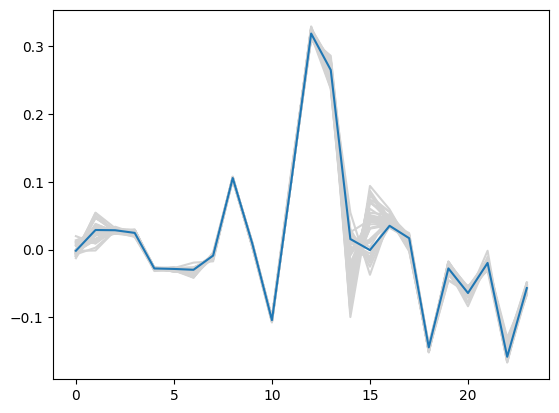

In [18]:
[plt.plot(actions['Building_7'][i], c="lightgray") for i in range(50)]
plt.plot(mpc_de.future_actions["Building_7"][0]);

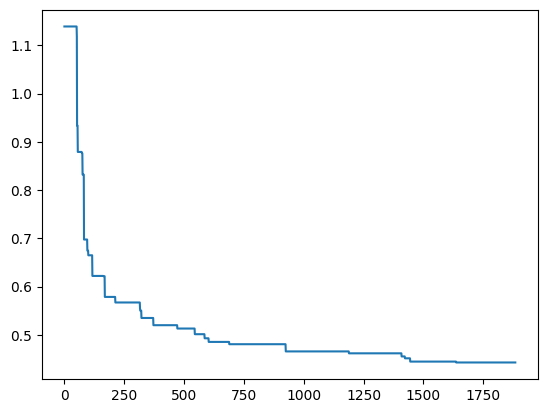

In [ ]:
plt.plot(best_obj_hist)

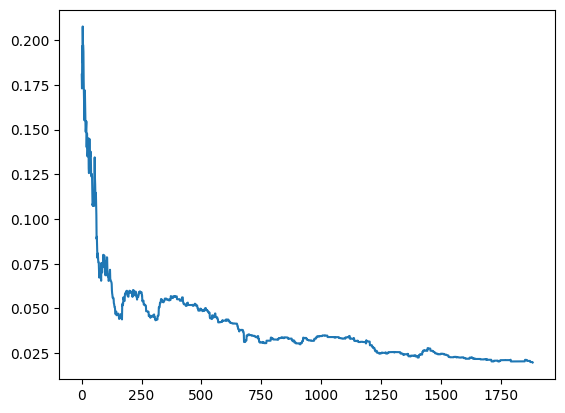

In [ ]:
plt.plot(convergence)

## dynamic constraint test

In [ ]:
a = np.random.uniform(-0.78125,0.78125,(5,24))
s = np.random.uniform(0,1,(5,24))

In [ ]:
cap = np.tile(np.array([6.4,6.4,6.4,6.4,6.4]).reshape(5,1),24-1)

In [ ]:
charge = np.multiply(a[:,1:], cap)

In [ ]:
dis_eff = np.tile((1/np.sqrt([0.9,0.9,0.9,0.9,0.9])).reshape(5,1),24-1)

In [ ]:
cha_eff = np.tile((np.sqrt([0.9,0.9,0.9,0.9,0.9])).reshape(5,1),24-1)

In [ ]:
const_char = np.multiply(charge, cha_eff)

In [ ]:
const_char

array([[-2.45840287e+00,  2.83325823e+00,  2.42423054e+00,
         3.63862171e+00,  3.71487967e+00,  3.48842764e-02,
        -1.40823527e+00,  4.10594059e+00, -2.33431071e+00,
        -4.49099301e+00, -1.13159354e+00, -4.03641135e+00,
         2.16889914e+00, -1.83297332e+00, -3.10605692e+00,
        -3.35528946e-01, -1.81961553e+00,  3.13219453e+00,
        -2.30010093e+00, -1.06198666e+00,  3.06759824e+00,
         2.18389222e+00,  3.50284627e+00],
       [-2.16006706e+00, -2.26175898e+00, -1.33313199e+00,
        -4.21072820e+00, -1.44665849e+00, -8.37938716e-01,
        -8.64045375e-01,  3.55760477e+00,  7.26168844e-01,
        -1.42514592e+00, -3.06005280e+00,  3.51583672e+00,
         2.10652794e+00,  1.55309851e+00,  3.12197631e+00,
         1.24568214e+00, -3.56639705e+00, -3.68103740e+00,
         2.33487626e+00, -3.76743335e+00, -2.75755537e+00,
         4.65862347e+00, -5.09242938e-01],
       [-3.17784524e+00, -4.31948221e+00, -3.09703246e+00,
         1.86472221e+00, -1.6

In [ ]:
const_dist = np.multiply(charge, dis_eff)

In [ ]:
const_dist

array([[-2.73155875e+00,  3.14806469e+00,  2.69358949e+00,
         4.04291301e+00,  4.12764408e+00,  3.87603071e-02,
        -1.56470586e+00,  4.56215621e+00, -2.59367857e+00,
        -4.98999223e+00, -1.25732615e+00, -4.48490150e+00,
         2.40988793e+00, -2.03663703e+00, -3.45117436e+00,
        -3.72809941e-01, -2.02179503e+00,  3.48021615e+00,
        -2.55566770e+00, -1.17998517e+00,  3.40844249e+00,
         2.42654691e+00,  3.89205141e+00],
       [-2.40007451e+00, -2.51306553e+00, -1.48125777e+00,
        -4.67858688e+00, -1.60739832e+00, -9.31043018e-01,
        -9.60050416e-01,  3.95289418e+00,  8.06854271e-01,
        -1.58349546e+00, -3.40005866e+00,  3.90648524e+00,
         2.34058660e+00,  1.72566501e+00,  3.46886257e+00,
         1.38409127e+00, -3.96266338e+00, -4.09004155e+00,
         2.59430696e+00, -4.18603706e+00, -3.06395041e+00,
         5.17624830e+00, -5.65825487e-01],
       [-3.53093916e+00, -4.79942468e+00, -3.44114718e+00,
         2.07191357e+00, -1.8